In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
c_drone_path = '../../../1mtmp/*.wav'
m_drone_path = '../../../20mtmp/*.wav'
f_drone_path = '../../../back/second-*.wav'
background_path = '../../../background/*.wav'

c_drone_files = glob.glob(c_drone_path)
m_drone_files = glob.glob(m_drone_path)
f_drone_files = glob.glob(f_drone_path)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
c_drone_raw = load(c_drone_files)
m_drone_raw = load(m_drone_files)
f_drone_raw = load(f_drone_files)
background_raw = load(background_files)

(512000,)
(1126400,)
(634880,)
(2797568,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
c_mfcc_drone, c_y_drone = mfcc4(c_drone_raw, 3)
m_mfcc_drone, m_y_drone = mfcc4(m_drone_raw, 2)
f_mfcc_drone, f_y_drone = mfcc4(f_drone_raw, 1)
mfcc_background, y_background = mfcc4(background_raw, 0)

print(c_mfcc_drone.shape, c_y_drone.shape)
print(m_mfcc_drone.shape, m_y_drone.shape)
print(f_mfcc_drone.shape, f_y_drone.shape)

print(mfcc_background.shape, y_background.shape)

(512000,)
small end: (16, 9)
(1126400,)
small end: (16, 9)
(634880,)
small end: (16, 9)
(2797568,)
small end: (16, 9)
(124, 16, 16) (124,)
(274, 16, 16) (274,)
(154, 16, 16) (154,)
(682, 16, 16) (682,)


In [8]:
X = np.concatenate((c_mfcc_drone, m_mfcc_drone, f_mfcc_drone, mfcc_background), axis=0)
y = np.hstack((c_y_drone, m_y_drone, f_y_drone, y_background))
print(X.shape, y.shape)

(1234, 16, 16) (1234,)


In [9]:
n_labels = y.shape[0]
n_unique_labels = 4
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(1234, 4)


In [10]:
X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
print(X_train2.shape)

(1234, 16, 16, 1)


In [11]:
n_mfcc = 16
n_frame = 16
n_classes = 4
n_channels = 1
learning_rate = 0.0002  ## 괜찮나용?

In [12]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])


conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)
conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=4)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [13]:
sess = tf.Session()
saver = tf.train.Saver()
# 모델 불러오는 path
saver.restore(sess, '../../model/CNN/4_cnn_model')

INFO:tensorflow:Restoring parameters from ../../model/CNN/4_cnn_model


In [14]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X:X_train2})
y_pred = sess.run(tf.argmax(logits,1), feed_dict={X:X_train2})
y_true = sess.run(tf.argmax(y_encoded,1))

In [15]:
import pandas as pd
pd.options.display.max_rows = 4000
print(pd.DataFrame(y_test))

                 0             1             2             3
0     9.927371e-30  0.000000e+00  0.000000e+00  1.000000e+00
1     3.815362e-10  0.000000e+00  0.000000e+00  1.000000e+00
2     1.986592e-22  0.000000e+00  0.000000e+00  1.000000e+00
3     1.953288e-29  0.000000e+00  0.000000e+00  1.000000e+00
4     9.834915e-29  0.000000e+00  0.000000e+00  1.000000e+00
5     8.948637e-12  0.000000e+00  1.328708e-29  1.000000e+00
6     1.047677e-26  0.000000e+00  0.000000e+00  1.000000e+00
7     2.001305e-20  0.000000e+00  2.097099e-37  1.000000e+00
8     4.839194e-22  0.000000e+00  2.596051e-29  1.000000e+00
9     5.968877e-10  5.253208e-25  2.366042e-28  1.000000e+00
10    7.057115e-04  3.261636e-20  1.768283e-34  9.992943e-01
11    9.999925e-01  7.105457e-19  0.000000e+00  7.514125e-06
12    1.000000e+00  2.598312e-20  0.000000e+00  2.542287e-14
13    1.000000e+00  1.343960e-36  0.000000e+00  1.794304e-23
14    6.614001e-05  2.768831e-08  1.345167e-13  9.999338e-01
15    9.777908e-01  2.15

F-Score: 0.686
Accuracy:  0.6855753646677472
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       682
           1       0.11      0.05      0.06       154
           2       0.85      0.38      0.52       274
           3       0.30      0.90      0.45       124

   micro avg       0.69      0.69      0.69      1234
   macro avg       0.54      0.56      0.49      1234
weighted avg       0.74      0.69      0.68      1234

[[624  32   6  20]
 [ 21   7  13 113]
 [ 23  25 104 122]
 [ 12   1   0 111]]


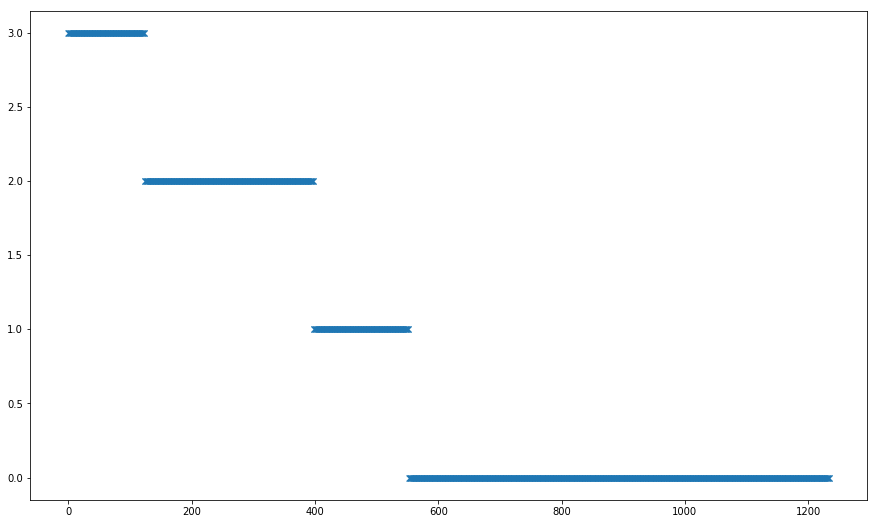

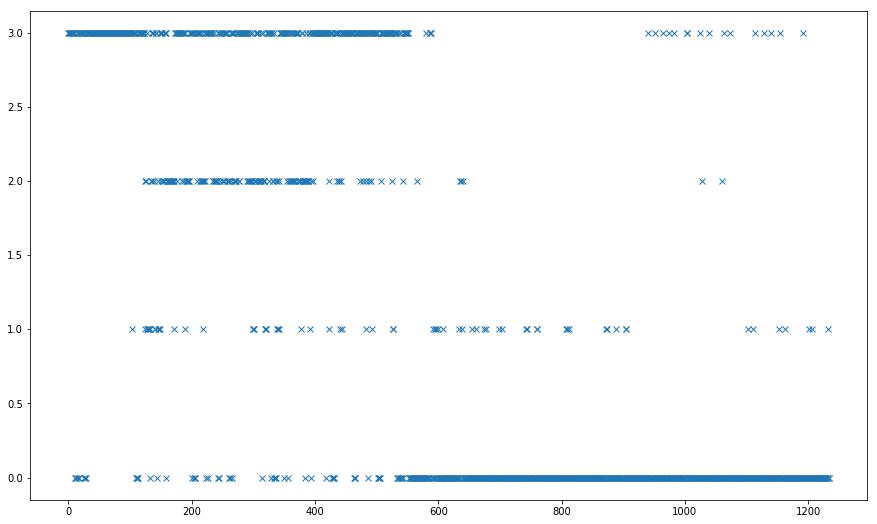

In [16]:
# Print Result
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))